In [1]:
import sys
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    mutual_info_classif as MIC,
)
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.naive_bayes import GaussianNB


In [2]:
data = pd.read_csv("../../data/rice_msc_dataset.csv")
data.head()


,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,ALLdaub4L,ALLdaub4a,ALLdaub4b,ALLdaub4Y,ALLdaub4Cb,ALLdaub4Cr,ALLdaub4XX,ALLdaub4YY,ALLdaub4ZZ,CLASS
0,7805,437.915,209.8215,48.0221,0.9735,99.6877,0.9775,7985,0.3547,4.3693,...,113.9924,65.0610,59.5989,104.8552,67.8779,63.0828,0.3673,0.3793,0.4733,Basmati
1,7503,340.757,138.3361,69.8417,0.8632,97.7400,0.9660,7767,0.6637,1.9807,...,105.7055,64.3685,62.2084,96.8375,65.5371,63.5832,0.3014,0.3144,0.3641,Arborio
2,5124,314.617,141.9803,46.5784,0.9447,80.7718,0.9721,5271,0.4760,3.0482,...,109.7155,62.6423,58.7439,100.2352,68.9753,59.8342,0.3233,0.3445,0.4448,Jasmine
3,7990,437.085,201.4386,51.2245,0.9671,100.8622,0.9659,8272,0.6274,3.9325,...,116.5405,64.9069,60.2562,107.2560,67.3298,63.2237,0.3880,0.4020,0.4904,Basmati
4,7433,342.893,140.3350,68.3927,0.8732,97.2830,0.9831,7561,0.6006,2.0519,...,107.7502,64.7071,61.3549,98.8704,66.2048,63.5378,0.3184,0.3303,0.3928,Arborio


#### CZĘŚĆ 1: Podstawowa eksploracja danych ####

AREA            0
PERIMETER       0
MAJOR_AXIS      0
MINOR_AXIS      0
ECCENTRICITY    0
               ..
ALLdaub4Cr      0
ALLdaub4XX      0
ALLdaub4YY      0
ALLdaub4ZZ      0
CLASS           0
Length: 107, dtype: int64
              precision    recall  f1-score   support

     Arborio       0.48      0.50      0.49      1510
     Basmati       0.50      0.49      0.50      1475
      Ipsala       0.97      0.97      0.97      1464
     Jasmine       0.82      0.84      0.83      1540
   Karacadag       0.73      0.69      0.71      1511

    accuracy                           0.70      7500
   macro avg       0.70      0.70      0.70      7500
weighted avg       0.70      0.70      0.70      7500



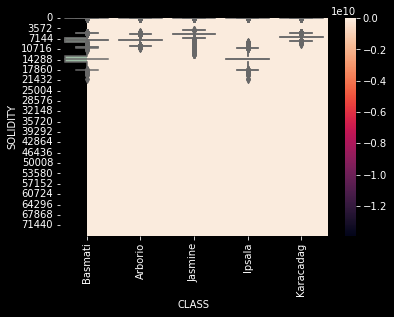

In [3]:
# Sprawdzamy czy są jakieś missing values
data.isnull().values.any()  # Są
ile_brakuje = data.isnull().sum()

print(ile_brakuje)

ile_brakuje[
    ile_brakuje > 0
]  # Zmienne dla których są jakies brakujące wartosci

# Usunę wiersze z brakującymi wartosciami.

data2 = data.dropna()  # Nowe dane
len(data.index) - len(
    data2.index
)  # Czyli było 8 wierszy z brakującymi zmiennymi

data2 = data2.reset_index()

# Tworzymy roboczy zbiór danych bez ostatniej kolumny

data3 = data2.drop(["CLASS"], axis=1)

data3 = data3.drop(["index"], axis=1)

data4 = data2[["CLASS"]]

# Macierz korelacji
# Zbadamy skorelowanie poszczególnych zmiennych (docelowo objasniających),
# żeby zdecydować których nie ma sensu wspólnie używać przy przewidywaniu rodzaju ryżu.

sns.heatmap(data3)  # nie widać tutaj zbyt wiele

M = data3.corr()

# Wypisujemy "Mocno" dla elementów macierzy, w których korelacja > 0.9
M[abs(M) > 0.9] = "Mocno"

# Rysujemy boxploty dotyczące AREA dla różnych rodzajów ryżu

data_powierzchnia = data2[["AREA", "CLASS"]]

box_area = sns.boxplot(
    x="CLASS", y="AREA", data=data_powierzchnia, color="#99c2a2"
)

Ipsala = data_powierzchnia.loc[data_powierzchnia["CLASS"] == "Ipsala"]
Ipsala = Ipsala.reset_index()


Ipsala[(Ipsala["AREA"] > 12500) & (Ipsala["AREA"] < 15000)].shape[
    0
]  # ponad połowa wartosci w srodku boxplota: 8827

Ipsala[Ipsala["AREA"] > 17000].shape[0]  # 260
Ipsala[Ipsala["AREA"] > 20000].shape[0]  # 1 mocny outlier

Ipsala[Ipsala["AREA"] < 10000].shape[0]  # 111

Ipsala["AREA"].mean()
Ipsala["AREA"].median()

ax2 = sns.boxplot(x="CLASS", y="AREA", data=Ipsala, color="#99c2a2")

ax = sns.boxplot(x="CLASS", y="AREA", data=data_powierzchnia, color="#99c2a2")
# Boxplot stworzony dla wszystkich typów ryżu wskazuje na to, że są istotne różnice w powierzchni jeżeli chodzi o Ipsala, Karacadag, Jasmine,
# natomiast zbadanie powierzchni nie odróżni nam od siebie Basmati i Arborio.

# Weźmiemy jeszcze trwałosć, żeby może odróżnić dwa pozostałe rodzaje ryżu

data_trwalosc = data2[["SOLIDITY", "CLASS"]]

box_trwalosc = sns.boxplot(
    x="CLASS", y="SOLIDITY", data=data_trwalosc, color="#99c2a2"
)
# Powinno nam odróżnić basmati od arborio
# KNN
X, Y = data[["AREA", "SOLIDITY"]], data["CLASS"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
przewidziane = knn.predict(X_test)

print(classification_report(Y_test, przewidziane))



## CZĘŚĆ 2: Feature selection - DRZEWA DECYZYJNE 


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data3, data4, test_size=0.1
)


In [5]:
mi_score = MIC(X_train, Y_train.values.ravel())
print(mi_score)


[0.9222672  0.95153369 0.94509252 0.97918273 1.28682013 0.92148427
 0.22582828 0.92330146 0.49420704 1.28719163 1.31883341 1.29603698
 0.98487244 0.92334715 1.29489125 0.20517238 0.54769565 0.52174951
 0.28416738 0.61987908 0.62350495 0.61390085 0.37434653 0.40892057
 0.32990184 0.5375414  0.56390541 0.48112958 0.80729879 0.86108037
 0.83441858 0.58267955 0.61355614 0.35087569 0.32771852 0.57116246
 0.6672937  0.31161098 0.43460577 0.40423717 0.19915763 0.30147511
 0.56667159 0.54636941 0.52920061 0.31627468 0.52084322 0.77290635
 0.88141344 0.6407397  0.52851842 0.57367353 0.38941369 0.44327624
 0.44272523 0.55089628 0.18301439 0.28174977 0.87020658 0.83865321
 0.9007467  0.50827953 0.87409289 0.47941098 0.62996041 0.57716041
 0.38755722 0.36235985 0.43288547 0.2207219  0.54397606 0.23191625
 0.18368543 0.86428063 0.82758197 0.85430274 0.48958836 0.50694028
 0.28628026 0.48382792 0.46961871 0.53518613 0.26683194 0.31938761
 0.23617321 0.56235554 0.5787765  0.49038165 0.62529991 0.4106

(array([14., 15., 22., 25.,  2.,  9., 12.,  2.,  0.,  5.]),
 array([0.18301439, 0.29659629, 0.41017819, 0.5237601 , 0.637342  ,
        0.7509239 , 0.8645058 , 0.9780877 , 1.09166961, 1.20525151,
        1.31883341]),
 <BarContainer object of 10 artists>)

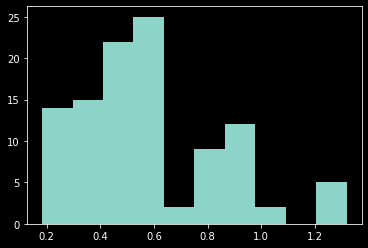

In [6]:
np.histogram(mi_score)
plt.hist(
    mi_score
)  # widzimy, że najwięcej zmiennych wpada w przedział [0.4,0.6]


In [7]:
mi_score_selected_index = np.where(mi_score > 0.5)[0]
# wybiorę zmienne, które mają mi_score > 0.5


In [8]:
X_2 = data3[data3.columns[mi_score_selected_index - 1]]
# wybieram zmienne z odpowiednio dużym mi_score


In [9]:
X_train_2, X_test_2, Y_train2, Y_test2 = train_test_split(
    X_2, data4, test_size=0.1
)


In [10]:
model_1 = DTC().fit(X_train, Y_train)
model_2 = DTC().fit(X_train_2, Y_train2)

score_1 = model_1.score(X_test, Y_test)
score_2 = model_2.score(X_test_2, Y_test2)

print(f"score_1:{score_1}\n score_2:{score_2}\n")


score_1:0.996
 score_2:0.9958666666666667



In [11]:
data3.columns[mi_score_selected_index - 1]


Index(['ALLdaub4ZZ', 'AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS',
       'ECCENTRICITY', 'SOLIDITY', 'EXTENT', 'ASPECT_RATIO', 'ROUNDNESS',
       'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2', 'SHAPEFACTOR_4',
       'meanRR', 'meanRB', 'StdDevRR', 'StdDevRG', 'skewRB', 'kurtosisRR',
       'kurtosisRB', 'entropyRR', 'entropyRG', 'entropyRB', 'meanH', 'StdDevH',
       'StdDevS', 'kurtosisS', 'kurtosisV', 'entropyH', 'entropyV', 'meanL',
       'meanA', 'meanB', 'StdDevL', 'StdDevA', 'skewB', 'kurtosisB',
       'entropyL', 'entropyA', 'entropyB', 'meanY', 'meanCr', 'StdDevY',
       'skewCr', 'kurtosisCr', 'entropyY', 'entropyCb', 'meanXX', 'StdDevYY',
       'skewZZ', 'kurtosisXX', 'kurtosisZZ', 'entropyZZ', 'ALLdaub4RR',
       'ALLdaub4RB', 'ALLdaub4H', 'ALLdaub4V', 'ALLdaub4L', 'ALLdaub4a',
       'ALLdaub4b', 'ALLdaub4Y', 'ALLdaub4XX'],
      dtype='object')

In [12]:
# liczba zmiennych objasniajacych które zostały:

len(data3.columns[mi_score_selected_index - 1])
# Czyli widzimy, że pomimo usunięcia 63 zmiennych, model praktycznie nie stracił na jakosci


63

In [13]:
################################################
# Spróbujmy pójsć dalej.
################################################

mi_score_selected_index2 = np.where(mi_score > 0.8)[
    0
]  # wybiorę zmienne, które mają mi_score > 0.5

X_3 = data3[
    data3.columns[mi_score_selected_index2 - 1]
]  # wybieram zmienne z odpowiednio dużym mi_score


X_train_3, X_test_3, Y_train3, Y_test3 = train_test_split(
    X_3, data4, test_size=0.1
)

model_3 = DTC().fit(X_train_3, Y_train3)
score_3 = model_3.score(X_test_3, Y_test3)

print(f"score_1:{score_1}\n score_3:{score_3}\n")


score_1:0.996
 score_3:0.9901333333333333



In [14]:
# pozostałe kolumny w feature selection:

data3.columns[mi_score_selected_index2 - 1]


Index(['ALLdaub4ZZ', 'AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS',
       'ECCENTRICITY', 'SOLIDITY', 'EXTENT', 'ASPECT_RATIO', 'ROUNDNESS',
       'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2', 'kurtosisRB',
       'entropyRR', 'entropyRG', 'meanA', 'kurtosisB', 'entropyL', 'entropyA',
       'meanY', 'kurtosisCr', 'entropyY', 'entropyCb', 'ALLdaub4a',
       'ALLdaub4Y'],
      dtype='object')

In [15]:
# liczba zmiennych objasniajacych które zostały:

len(data3.columns[mi_score_selected_index2 - 1])  # 26

################################################
# Wciąż jest bardzo dobrze, idziemy dalej.
################################################


26

In [16]:
mi_score_selected_index3 = np.where(mi_score > 0.95)[
    0
]  # wybiorę zmienne, które mają mi_score > 0.5

X_4 = data3[
    data3.columns[mi_score_selected_index2 - 1]
]  # wybieram zmienne z odpowiednio dużym mi_score


X_train_4, X_test_4, Y_train4, Y_test4 = train_test_split(
    X_4, data4, test_size=0.1
)

model_4 = DTC().fit(X_train_4, Y_train4)
score_4 = model_4.score(X_test_4, Y_test4)

print(f"score_1:{score_1}\n score_4:{score_4}\n")


score_1:0.996
 score_4:0.994



In [17]:
data3.columns[mi_score_selected_index3 - 1]


Index(['AREA', 'MAJOR_AXIS', 'MINOR_AXIS', 'EXTENT', 'ASPECT_RATIO',
       'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_2'],
      dtype='object')

In [18]:
len(data3.columns[mi_score_selected_index3 - 1])  # 8


8

##### CZĘŚĆ 3: LASY LOSOWE 


In [19]:
model = RF()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(
    model,
    X_train_4,
    Y_train4,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    error_score="raise",
)

print("Accuracy: %.3f (%.3f)" % (mean(n_scores), std(n_scores)))
# Accuracy 0.995 - jestesmy bardzo zadowoleni


/home/mchraba/anaconda3/envs/rice_classification/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/mchraba/anaconda3/envs/rice_classification/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/mchraba/anaconda3/envs/rice_classification/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/mchraba/anaconda3/envs

Accuracy: 0.995 (0.001)


#### CZĘŚĆ 4: NAIWNY BAYES 

In [20]:
gnb = GaussianNB()
Y_pred = gnb.fit(X_train_4, Y_train4.values.ravel()).predict(X_test_4)

print(classification_report(Y_test4, Y_pred))


              precision    recall  f1-score   support

     Arborio       0.51      0.34      0.41      1524
     Basmati       0.53      0.61      0.57      1488
      Ipsala       0.98      0.99      0.99      1513
     Jasmine       0.90      0.71      0.79      1480
   Karacadag       0.61      0.85      0.71      1495

    accuracy                           0.70      7500
   macro avg       0.71      0.70      0.69      7500
weighted avg       0.71      0.70      0.69      7500



In [21]:
# Sprawdzmy jeszcze dla wiekszej liczby zmiennych

Y_pred_wiecej = gnb.fit(X_train_3, Y_train3.values.ravel()).predict(X_test_3)

print(classification_report(Y_test3, Y_pred_wiecej))


              precision    recall  f1-score   support

     Arborio       0.51      0.34      0.41      1542
     Basmati       0.53      0.62      0.57      1485
      Ipsala       0.98      0.99      0.98      1452
     Jasmine       0.90      0.68      0.77      1485
   Karacadag       0.61      0.85      0.71      1536

    accuracy                           0.69      7500
   macro avg       0.70      0.70      0.69      7500
weighted avg       0.70      0.69      0.69      7500

